In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import os

In [2]:
figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

In [3]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
    
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ["\\usepackage{libertine}"],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
#               'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'mathtext.default': 'regular'
    }

    matplotlib.rcParams.update(params)

%matplotlib inline

latexify()

In [4]:
def process_solve_status(s):
    if s == "Infeasible" or s == "Unbounded" or s == "InfeasibleOrUnbounded":
        return "ProvablyRobustByClass"
    elif s == "InfeasibleDistance":
        return "ProvablyRobustByDistance"
    elif s.startswith("InfeasibleDistance"):
        min_threshold = float(s[18:])
        return min_threshold
    elif s.startswith("InfeasibleUndecidedDistance"):
        min_threshold = float(s[27:])
        return min_threshold
    elif s == "UserLimit":
        return "StatusUnknown"
    else:
        return "Vulnerable"

In [5]:
mnist_valid_labels = pd.read_csv("parser/mnist_valid_labels.csv").set_index("SampleNumber")
mnist_test_labels = pd.read_csv("parser/mnist_test_labels.csv").set_index("SampleNumber")

def get_accuracies_valid(filename):
    dt = pd.read_csv(filename)
    dt.SampleNumber -=1
    dt.PredictedIndex -=1
    dt = dt.drop_duplicates(
        subset = "SampleNumber", keep="last"
    ).set_index("SampleNumber").sort_index().join(mnist_valid_labels)

    dt["ProcessedSolveStatus"] = dt["SolveStatus"].apply(process_solve_status)

    adv_results = dt.groupby("ProcessedSolveStatus")["SolveStatus"].count().to_dict()
    cumulative_adv_results = []
    accumulator = adv_results["ProvablyRobustByClass"]
    for i in range(-24, 41):
        if (i / 10) in adv_results:
            accumulator += adv_results[i / 10]
        cumulative_adv_results.append(accumulator)

    nat_results = [
        np.logical_and(
            dt["NaturalInputMinDistance"].values >= x / 10,
            (dt.PredictedIndex == dt.TrueIndex).values
        ).sum()
        for x in range(-24, 41)
    ]

    return(np.asarray(nat_results) / sum(adv_results.values()),
        (np.asarray(cumulative_adv_results) / sum(adv_results.values())))

def get_accuracies_test(filename, threshold):
    dt = pd.read_csv(filename)
    dt.SampleNumber -=1
    dt.PredictedIndex -=1
    dt = dt.drop_duplicates(
        subset = "SampleNumber", keep="last"
    ).set_index("SampleNumber").sort_index().join(mnist_test_labels)

    nat_results = np.logical_and(dt["NaturalInputMinDistance"].values >= threshold,
                                 (dt.PredictedIndex == dt.TrueIndex).values).sum()

    dt["ProcessedSolveStatus"] = dt["SolveStatus"].apply(process_solve_status)
    adv_results = dt.groupby("ProcessedSolveStatus")["PredictedIndex"].count().to_dict()

    return (nat_results / dt["PredictedIndex"].count(),
            (adv_results["ProvablyRobustByClass"]
             + adv_results["ProvablyRobustByDistance"]) / dt["PredictedIndex"].count())

In [6]:
# def count_while(arr, pred, index = 0):
#     count = 0
#     while count + index < len(arr) and pred(arr[count + index]):
#         count += 1
#     return count

# def get_accuracies(filename):
#     dt = pd.read_csv(filename)
#     dt = dt.drop_duplicates(subset = "SampleNumber", keep="last")
#     dt["ProcessedSolveStatus"] = dt["SolveStatus"].apply(process_solve_status)
    
#     adv_results = dt.groupby("ProcessedSolveStatus")["SampleNumber"].count().to_dict()
#     cumulative_adv_results = []
#     accumulator = adv_results["ProvablyRobustByClass"]
#     for i in range(-24, 41):
#         if (i / 10) in adv_results:
#             accumulator += adv_results[i / 10]
#         cumulative_adv_results.append(accumulator)
    
#     nat_results = sorted(dt["NaturalInputMinDistance"].values)
#     cumulative_nat_results = []
#     accumulator = 0
#     for i in range(-24, 41):
#         accumulator += count_while(nat_results, lambda x: x < i / 10, accumulator)
#         cumulative_nat_results.append(accumulator)
    
#     return((1 - np.asarray(cumulative_nat_results) / len(nat_results)),
#         (np.asarray(cumulative_adv_results) / sum(adv_results.values())))

0.9904 0.9744
Maximise nat and adv accuracy at epsilon =  0.6
Nat accuracy 0.9818
Adv accuracy 0.9824 

0.9746 0.9296
Maximise nat and adv accuracy at epsilon =  0.5
Nat accuracy 0.9396
Adv accuracy 0.94 

0.9674 0.8268
Maximise nat and adv accuracy at epsilon =  1.4
Nat accuracy 0.885
Adv accuracy 0.8828 



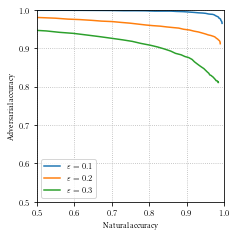

In [7]:
plt.figure()

# Set height = width
fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width, width)


for dataset, label in zip(["mnist_improved_ia_0.1__linf-norm-bounded-0.1__Inf__0.0",
                           "mnist_improved_ia_0.2__linf-norm-bounded-0.2__Inf__0.0",
                           "mnist_improved_ia_0.3__linf-norm-bounded-0.3__Inf__0.0"],
                          ["$\\varepsilon = 0.1$", "$\\varepsilon = 0.2$", "$\\varepsilon = 0.3$"]):

    filename = "verification/results_validation/" + dataset + "/summary.csv"
    nat_accuracies, adv_accuracies = get_accuracies_valid(filename)
    plt.plot(nat_accuracies, adv_accuracies, label=label)
    plt.xlabel("Natural accuracy")
    plt.ylabel("Adversarial accuracy")
    
    plt.grid(True, "both", linestyle="dotted")
    
    print(nat_accuracies[24], adv_accuracies[24])

    max_min = 0
    nat_acc = -1
    adv_acc = -1
    epsilon = 0
    for (a, b, c) in zip(nat_accuracies, adv_accuracies, range(-24, 41)):
        if min(a, b) > max_min:
            max_min = min(a, b)
            nat_acc = a
            adv_acc = b
            epsilon = c / 10

    print("Maximise nat and adv accuracy at epsilon = ", epsilon)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")
    
#     plt.plot((nat_acc, nat_acc), (0, adv_acc), "k--")
#     plt.plot((0, nat_acc), (adv_acc, adv_acc), "k--")

plt.axis([0.5,1,0.5,1])
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "verif_results_mnist_valid.pdf"), bbox_inches="tight", pad_inches=0)

In [8]:
for dataset, threshold in [("mnist_improved_ia_0.1__linf-norm-bounded-0.1__Inf__0.0", 0.6),
                           ("mnist_improved_ia_0.2__linf-norm-bounded-0.2__Inf__0.0", 0.5),
                           ("mnist_improved_ia_0.3__linf-norm-bounded-0.3__Inf__0.0", 1.4)]:

    filename = "verification/results_test/" + dataset + "/summary.csv"
    nat_acc, adv_acc = get_accuracies_test(filename, threshold)
    
    print(dataset[:21], "with distance threshold", threshold)
    print("Nat accuracy", nat_acc)
    print("Adv accuracy", adv_acc, "\n")

mnist_improved_ia_0.1 with distance threshold 0.6
Nat accuracy 0.9621
Adv accuracy 0.9684 

mnist_improved_ia_0.2 with distance threshold 0.5
Nat accuracy 0.924
Adv accuracy 0.933 

mnist_improved_ia_0.3 with distance threshold 1.4
Nat accuracy 0.8609
Adv accuracy 0.8822 

